In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [196]:
#define time range
t_start = 2.50
duration = 0.07
t_end = t_start + duration
shape = (180, 240)
dataset = "data/esim_data/line_top/"

In [197]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=10000000)

In [198]:
sub_factor=1

In [199]:
# patch_center = (80, 70)
# patch_size = 50
# patch_center = (90, 90)
# patch_size = 180
# shape = (patch_size, patch_size)
# events_p = flt.filter_patch(events_raw, patch_center, patch_size)

In [200]:
# events_conv, new_shape = flt.filter_conv(events_p, shape, factor=sub_factor)
# shape = new_shape
# print(shape)

In [201]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = vis.events2img(events_conv, shape, filter_polarity=False, polarity=1)
# img_m = np.ma.masked_where(img == 0, img)
# m = plt.imshow(img_m, interpolation="none")
# #plt.colorbar(mappable=m)

In [202]:
events = flt.filter_refract(events_raw, 0.2)

In [203]:
events = flt.filter_time(events, t_start, t_end)

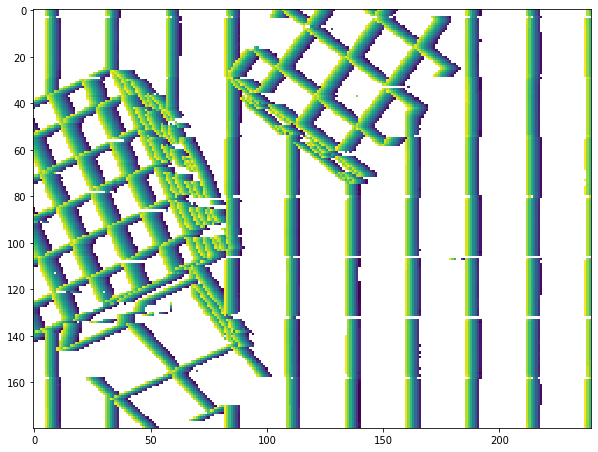

In [204]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [205]:
calib = np.loadtxt(path + dataset + "calib.txt") / sub_factor
calib[0] = 200
calib[1] = 200
calib[2] = 120
calib[3] = 90

In [206]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
# poses[:, [1, 2, 3]] = poses[:, [2, 3, 1]]

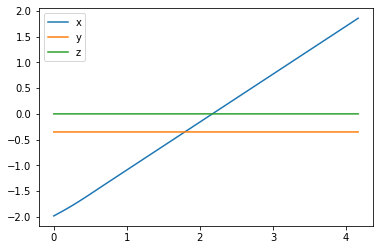

In [207]:
# k = np.ones(100)
# poses[:,1] = np.convolve(poses[:,1], k, mode="same")
# poses[:,2] = np.convolve(poses[:,2], k, mode="same")
# poses[:,3] = np.convolve(poses[:,3], k, mode="same")
# poses[:,4] = np.convolve(poses[:,4], k, mode="same")
# poses[:,5] = np.convolve(poses[:,5], k, mode="same")
# poses[:,6] = np.convolve(poses[:,6], k, mode="same")
# poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [208]:
# U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=5, std_thr=1.1, mean_thr=0.01, start_delay=0.05, final_delay=0.00)

In [209]:
U, V = td2d.measure_td_raw(events, shape, dist=1)

100%|█████████████████████████████████████████████████████████████████████████| 19243/19243 [00:00<00:00, 86721.76it/s]


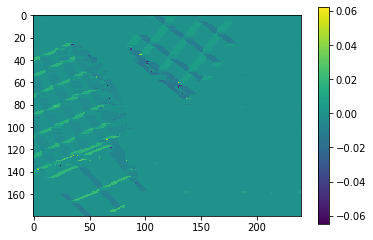

In [232]:
m = plt.imshow(V, interpolation="none")
plt.colorbar(m)

In [211]:
m = np.sqrt(U**2 + V**2)

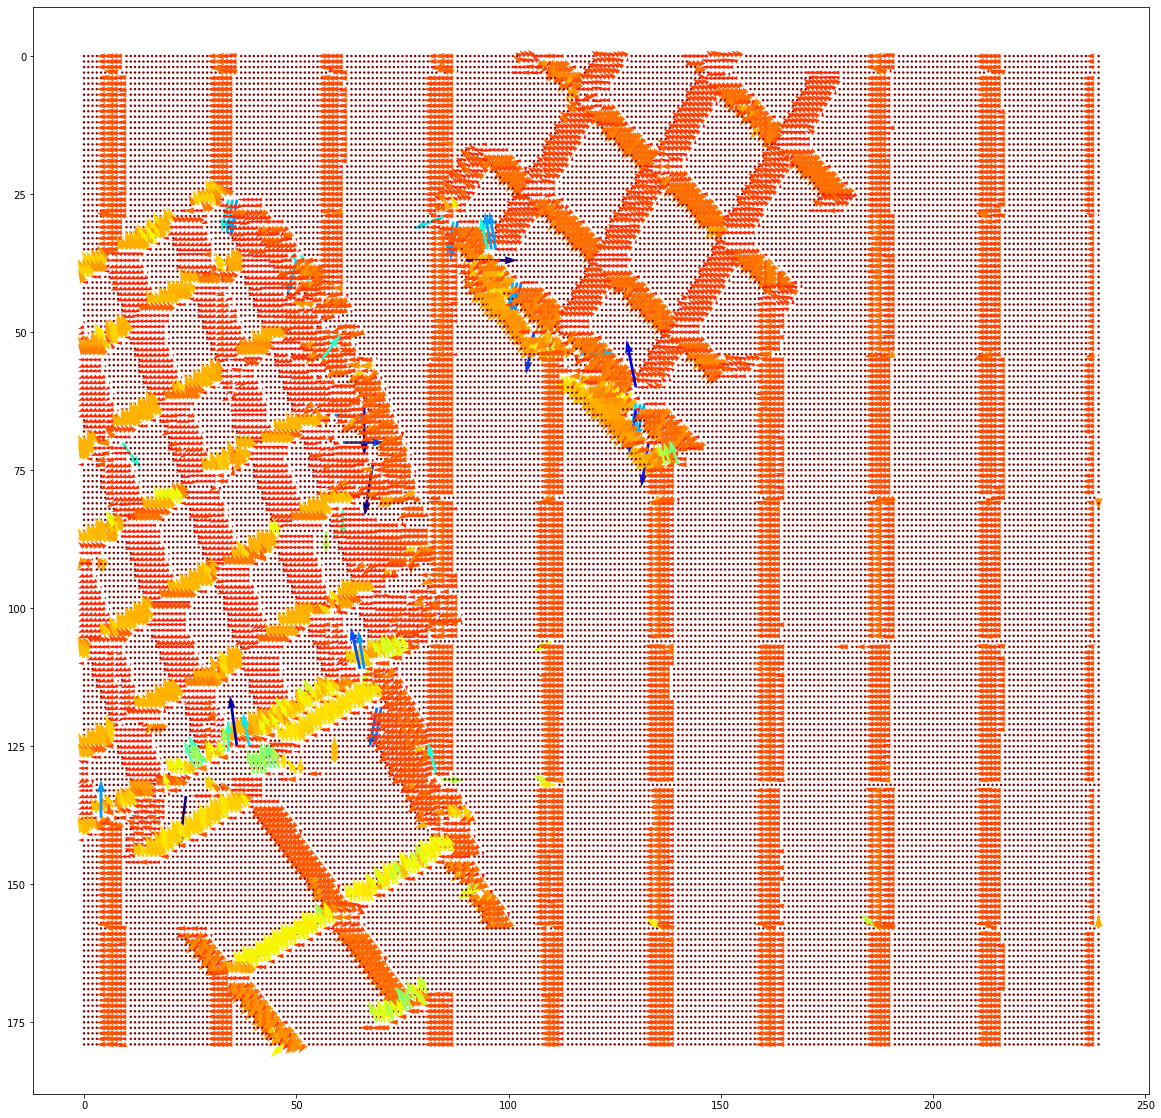

In [212]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

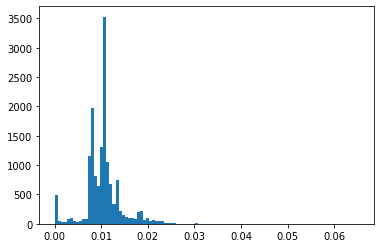

In [213]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [214]:
C = [calib[2], calib[3]]

In [215]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[0. 0. 0.]


In [216]:
ang_U, ang_V = flow_utils.get_angular_flow(vel, calib[0], C, shape)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


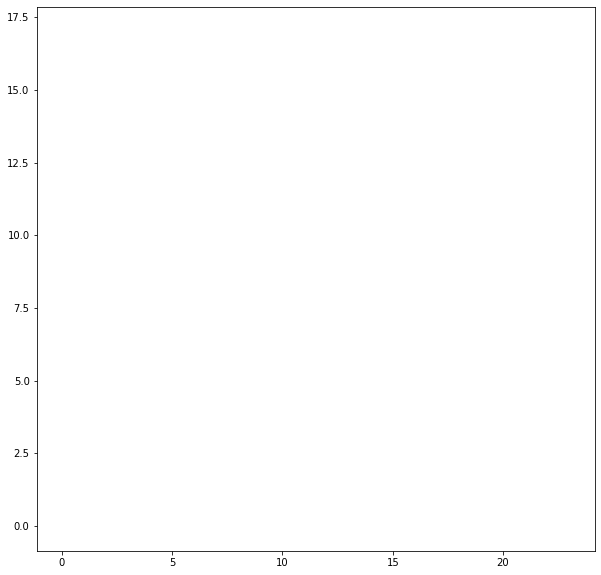

In [217]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [230]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

t_vel = (t2 - t1) / (pose2[0] - pose1[0])

print(t_vel)

[0.93101147 0.         0.        ]


In [219]:
t1

array([ 0.30756169, -0.351     ,  0.        ])

In [220]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, calib[0], C, shape)

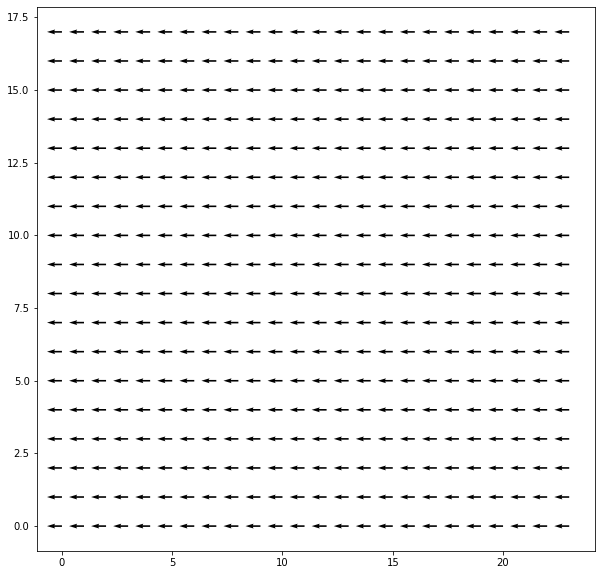

In [221]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [222]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

In [223]:
t_U

array([[-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347],
       [-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347],
       [-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347],
       ...,
       [-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347],
       [-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347],
       [-186.20229347, -186.20229347, -186.20229347, ..., -186.20229347,
        -186.20229347, -186.20229347]])

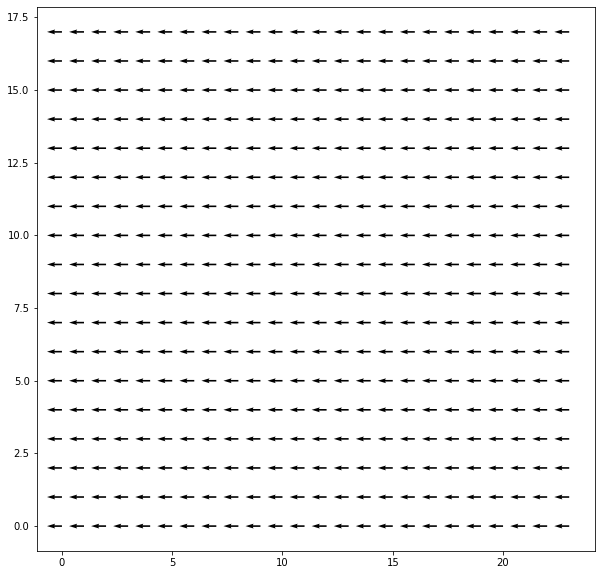

In [224]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [233]:
test, test_u, test_v = td2d.extract_depth(shape, U, V, t_U, t_V)

1.705988578453271


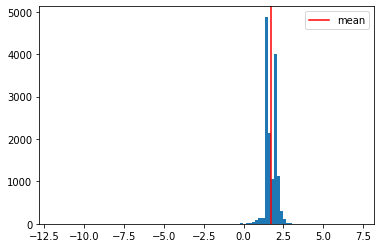

In [234]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);
plt.axvline(x=np.ma.mean(test_m), c="red", label="mean")
print(np.ma.mean(test_m))
plt.legend()

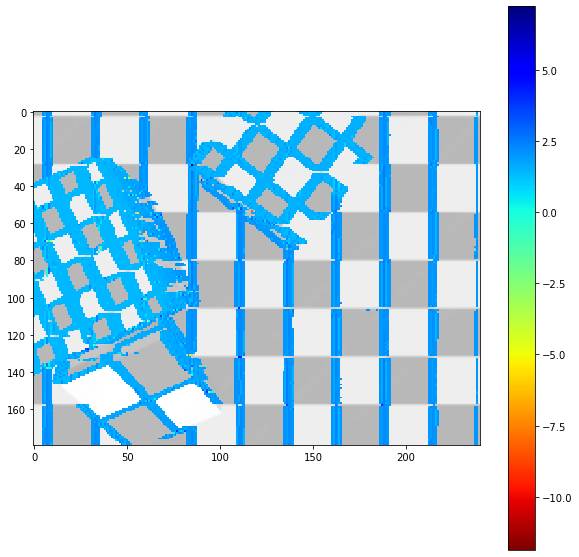

In [235]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "images/frame_00000074.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

In [249]:
test_f = td2d.median_filter(test_m, 7)

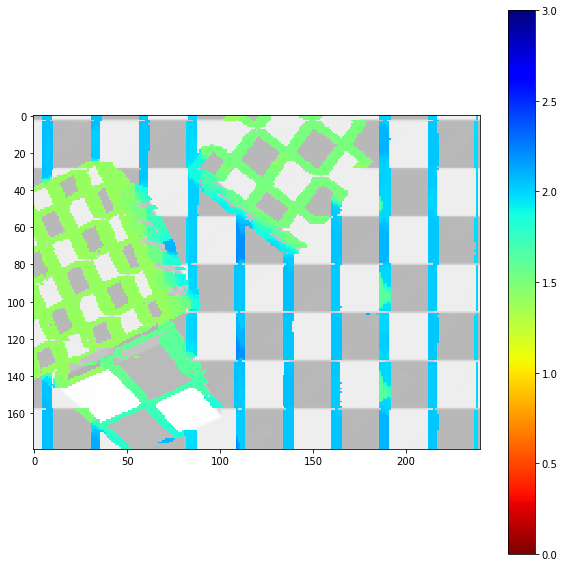

In [250]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "images/frame_00000074.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_f, interpolation="none", cmap="jet_r", vmin=0, vmax=3)
plt.colorbar(m)

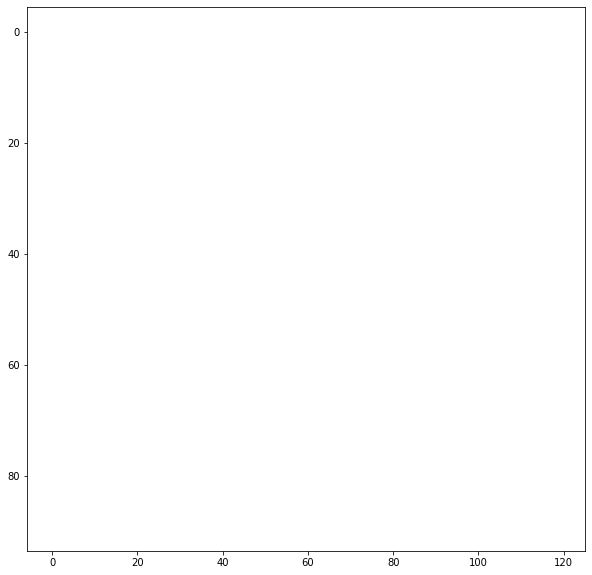

In [251]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 2
m = np.sqrt(np.square(test_u[::a, ::a]) + np.square(test_v[::a, ::a]))
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

In [252]:
# test_f = td2d.median_filter(test_m, 7)
# plt.figure(figsize=(20, 20))
# img_gray = plt.imread(path + dataset + "images/frame_00000076.png")
# plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
# m = plt.imshow(test_f, interpolation="none", cmap="jet_r")
# plt.colorbar(m)

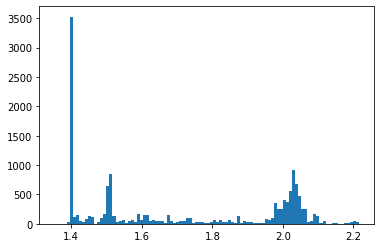

In [253]:
plt.hist(test_f.compressed(), 100);

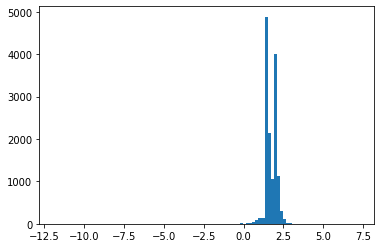

In [254]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [255]:
%matplotlib qt
vis.visualize3d(test_m, s=30, range=(0, 3))

In [256]:
d = test_f

In [257]:
points = vis._image2pointcloud(d)

gt = np.loadtxt(path + dataset + "groundtruth.txt")
idx = np.searchsorted(gt[:, 0], t_start)
p = gt[idx]
#p[[1, 2]] = p[[2, 1]]
print(p)

proj = td.project3d(points, calib, p)

[ 2.501       0.30756169 -0.351       0.          1.          0.
  0.          0.        ]


In [258]:
proj = proj[proj[:,2] > -3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=2)

o3d.visualization.draw_geometries([pcd])

-2.215694582088032
-1.3531346734829492
---


In [190]:
image_index = 74
gt_depths = np.load(path + dataset + "/depths.npy")

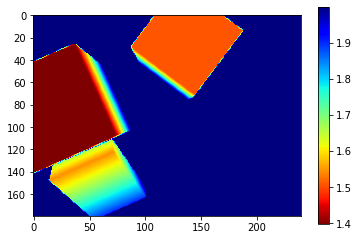

In [191]:
%matplotlib inline
m = plt.imshow(gt_depths[image_index], cmap="jet_r")
plt.colorbar(m)

In [192]:
gt_d = gt_depths[image_index,:,:180]
gt_m = np.ma.masked_where(test_f == 0.0, gt_d)

IndexError: Inconsistent shape between the condition and the input (got (180, 240) and (180, 180))

In [ ]:
diff = np.abs(test_f - gt_m)

In [ ]:
plt.hist(diff.compressed(), 100);
plt.axvline(x=np.ma.median(diff), c="red", label="mean")

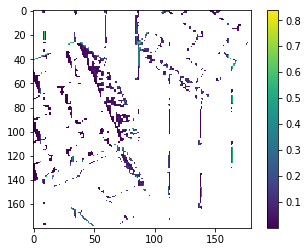

In [193]:
m = plt.imshow(diff)
plt.colorbar(m)

In [194]:
np.ma.median(diff)

0.044242809421481955

In [195]:
np.ma.mean(diff)

0.10190923371042275